# Gather IFS forecast files from WeatherBench 2

In [1]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import interp_utils as iu

In [4]:
config_name = os.path.realpath('verif_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [5]:
model_name = 'IFS'
filename_prefix = 'IFS_%Y-%m-%dT%HZ.nc'
save_loc = conf[model_name]['save_loc'] + filename_prefix

In [6]:
verif_ind_start = 2922; verif_ind_end = 2924
years_pick = np.arange(conf['IFS']['year_range'][0], conf['IFS']['year_range'][1]+1)

In [7]:
# import original IFS from WeatherBench GS
ds_IFS = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr')
ds_IFS = ds_IFS.isel(prediction_timedelta=slice(1, 41)) # <--- IFS lead time begins at 0, we drop 0
init_time = pd.to_datetime(ds_IFS['time'])

# Define the target 1-degree grid
lon_1deg = np.arange(0, 360, 1)
lat_1deg = np.arange(-90, 91, 1)
target_grid = iu.Grid.from_degrees(lon_1deg, lat_1deg)

lon_025deg = ds_IFS['longitude'].values
lat_025deg = ds_IFS['latitude'].values
source_grid = iu.Grid.from_degrees(lon_025deg, lat_025deg)

regridder = iu.ConservativeRegridder(source=source_grid, target=target_grid)

In [57]:
for i_dt, dt_index in enumerate(init_time[verif_ind_start:verif_ind_end]):
    
    # indexing could start from nonzero
    i_dt = i_dt + verif_ind_start
    
    # init year is within selection 
    if dt_index.year in years_pick:

        # get file name
        save_name = datetime.strftime(dt_index, save_loc)

        # save and skip exists
        if os.path.exists(save_name) is False:
            
            print('Processing {}'.format(os.path.basename(save_name)))
            # subset on initialization time
            ds_IFS_slice = ds_IFS.isel(time=slice(i_dt, i_dt+1))
            ds_IFS_slice = ds_IFS_slice.chunk({'longitude': -1, 'latitude': -1})
            
            ds_IFS_1deg = regridder.regrid_dataset(ds_IFS_slice)
            
            absolute_lead_time = np.array((dt_index + ds_IFS_1deg['prediction_timedelta'])) # time + delta
            ds_IFS_1deg = ds_IFS_1deg.squeeze('time')
            ds_IFS_1deg = ds_IFS_1deg.drop_vars('time')
            ds_IFS_1deg = ds_IFS_1deg.drop_vars('level')
            ds_IFS_1deg = ds_IFS_1deg.rename({'prediction_timedelta':'time'})
            ds_IFS_1deg['time'] = absolute_lead_time
            
            # Reorder the dimensions for all variables in ds_IFS_1deg
            for var in ds_IFS_1deg.data_vars:
                # Get the current dimensions of the variable
                current_dims = ds_IFS_1deg[var].dims
                
                # If both 'latitude' and 'longitude' are present, reorder them
                if 'latitude' in current_dims and 'longitude' in current_dims:
                    # New order
                    new_order = [
                        dim for dim in current_dims if dim not in ['latitude', 'longitude']
                    ] + ['latitude', 'longitude']
                    
                    # Transpose the variable to the new order
                    ds_IFS_1deg[var] = ds_IFS_1deg[var].transpose(*new_order)
            
            # Add latitude and longitude as coordinates to ds_IFS_1deg
            ds_IFS_1deg = ds_IFS_1deg.assign_coords({
                'latitude': lat_1deg,
                'longitude': lon_1deg
            })
            
            # flip latitude from -90 --> 90 to 90 --> -90
            ds_IFS_1deg = ds_IFS_1deg.isel(latitude=slice(None, None, -1))
            
            # float64 --> float32
            ds_IFS_1deg = ds_IFS_1deg.astype(
                {var: np.float32 for var in ds_IFS_1deg if ds_IFS_1deg[var].dtype == np.float64})
            
            # Convert latitude, longitude, and level coordinates to float32
            ds_IFS_1deg = ds_IFS_1deg.assign_coords({
                'latitude': ds_IFS_1deg['latitude'].astype(np.float32),
                'longitude': ds_IFS_1deg['longitude'].astype(np.float32),
                'level': ds_IFS_1deg['level'].astype(np.float32)
            })
            
            ds_IFS_1deg.to_netcdf(save_name)
            print('Save to {}'.format(save_name))
            raise

Processing IFS_2020-01-01T00Z.nc
Save to /glade/campaign/cisl/aiml/ksha/CREDIT_physics/GATHER/IFS/IFS_2020-01-01T00Z.nc


RuntimeError: No active exception to reraise

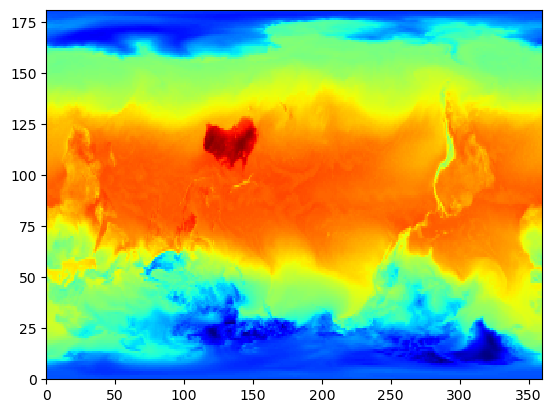

/glade/work/ksha/miniconda3/envs/credit/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [56]:
plt.pcolormesh(ds_IFS_1deg['2m_temperature'].values[0, ...], cmap=plt.cm.jet)